In [330]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
from os.path import join as oj

sys.path.append("../code")
from utils import load_precalculated_dataset,get_output, load_img_dataset,get_auc_f1
import numpy as np
from torchvision import  transforms
import pickle as pkl

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import os
from numpy.random import randint
import time
from torchvision import models
import copy
from tqdm import tqdm
from torch import nn
import pandas as pd
import seaborn as sns
sns.set()
import torch.nn.functional as F
from PIL import Image
import torch
device = torch.device("cuda")
pd.set_option('precision', 3)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
save_path = "../results_for_export"
trained_model_folder = '../models/ISIC/feature_models_gradient/'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder) if 'pkl'  in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1, sort = True).T.infer_objects() 


In [340]:
idx_best_loss = [np.asarray(x).argmax() for x in results['val_acc_history']]  
results['final_acc'] = [x[idx_best_loss[i]] for i,x in enumerate(results['val_acc_history'])] 
results['AUC (no patches)'] =[0 for x in results['regularizer_rate']]
results['F1 score (no patches)'] =[0 for x in results['regularizer_rate']]
results['F1 score (patches)'] =[0 for x in results['regularizer_rate']]
results['AUC (patches)'] =[0 for x in results['regularizer_rate']]
# results = results[results.regularizer_rate <100]

In [350]:
results[['regularizer_rate',
                       'final_acc', 
                       'AUC (no patches)',
                       'F1 score (no patches)',
                       'AUC (patches)',
                       'F1 score (patches)',]].groupby(by = 'regularizer_rate').mean()

,final_acc,AUC (no patches),F1 score (no patches),AUC (patches),F1 score (patches)
regularizer_rate,,,,,
0.1,0.880,0.665,0.386,0.816,0.382
1.0,0.881,0.652,0.376,0.810,0.372
10.0,0.883,0.656,0.379,0.815,0.374


In [349]:
results[['regularizer_rate',
                       'final_acc', 
                       'AUC (no patches)',
                       'F1 score (no patches)',
                       'AUC (patches)',
                       'F1 score (patches)', 'pid', 'seed']]

,regularizer_rate,final_acc,AUC (no patches),F1 score (no patches),AUC (patches),F1 score (patches),pid,seed
0,1.0,0.883,0.648,0.374,0.808,0.367,03422214843734487273,43
1,10.0,0.884,0.656,0.377,0.816,0.372,07358503564866650285,43
2,0.1,0.882,0.660,0.388,0.813,0.386,10201757613000220780,43
3,1.0,0.879,0.655,0.378,0.811,0.377,18167717327541163821,42
4,10.0,0.882,0.655,0.380,0.815,0.376,42405237664567855845,42
5,0.1,0.876,0.669,0.385,0.820,0.382,62508775403417245407,42
6,0.1,0.883,0.666,0.386,0.815,0.378,66888047501001825445,42


# Calculate ROC AUC

In [338]:
datasets = load_precalculated_dataset("../data/ISIC/calculated_features")
device = torch.device(0)
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device).eval()

In [348]:
f1_nopatches_dict = {}
auc_nopatches_dict = {}
f1_patches_dict = {}
auc_patches_dict = {}
for index, row in results[['regularizer_rate','pid',]].iterrows():
    fname = oj(trained_model_folder, str(row['pid']) + '.pt')
    auc_nopatches_dict[row['pid']], f1_nopatches_dict[row['pid']] = get_auc_f1(model, fname, datasets['test_no_patches'])
    auc_patches_dict[row['pid']], f1_patches_dict[row['pid']] = get_auc_f1(model, fname, datasets['test'])
results['AUC (no patches)'] =[auc_nopatches_dict[x] for x in results['pid']]
results['F1 score (no patches)'] =[f1_nopatches_dict[x] for x in results['pid']]
results['AUC (patches)'] =[auc_patches_dict[x] for x in results['pid']]
results['F1 score (patches)'] =[f1_patches_dict[x] for x in results['pid']]

# GradCAM

In [220]:
sys.path.append("../../pytorch-cnn-visualizations/src")
from tqdm import tqdm_notebook
from gradcam import GradCam
import torchvision.models as models
from PIL import Image
from utils import load_img_dataset

In [221]:
img_dataset = load_img_dataset("../../../datasets/ISIC/raw_data/")
mean = np.asarray([0.485, 0.456, 0.406]) 
std = np.asarray([0.229, 0.224, 0.225])

In [286]:

model_no_reg = models.vgg16(pretrained=True)
model_no_reg.classifier[-1] = nn.Linear(4096, 2)
model_no_reg = model_no_reg.eval()
model_no_reg.classifier.load_state_dict(torch.load('../models/ISIC/feature_models/54060285528710732317.pt')); # best performing vanilla model
model_reg = models.vgg16(pretrained=True)
model_reg.classifier[-1] = nn.Linear(4096, 2)
model_reg = model_reg.eval()
model_reg.classifier.load_state_dict(torch.load('../models/ISIC/feature_models/67515886646346654538.pt')); # best performing CDEP model

In [306]:
my_list_all = [img_dataset[i][0] for i in range(100) ]
my_list_targets_all = [1-img_dataset[i][1] for i in range(100) ]

In [307]:
model_reg = model_reg.cuda()
model_no_reg = model_no_reg.cuda()

grad_cam_noreg = GradCam(model_no_reg, target_layer=29)
grad_cam_reg = GradCam(model_reg, target_layer=29)

In [308]:
triples = []
for img, target in tqdm_notebook(zip(my_list_all[:100], my_list_targets_all[:100])):
    img.requires_grad= True
    test_img = img.cuda()
    test_img = test_img[None, :, :224, :224]
    img_np = img[:, :224, :224].detach().cpu().numpy().transpose(1,2,0)*std[None, None, :] + mean[None, None, :]
    reg_saliency = grad_cam_reg.generate_cam(test_img, target)
    vanilla_saliency = grad_cam_noreg.generate_cam(test_img, target)
    triples.append((img_np, vanilla_saliency, reg_saliency, target))

In [309]:
save_path = "../results_for_export"

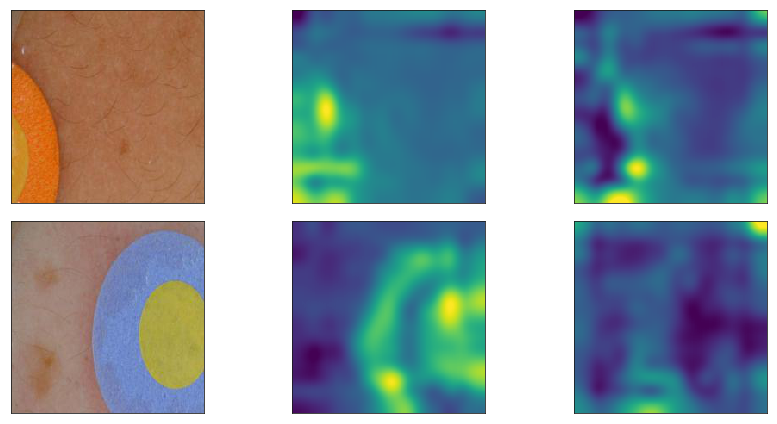

In [310]:

sns.reset_orig()
idxs = [34,76]
num_rows = len(idxs)

fig, axes = plt.subplots(num_rows,3, figsize=  (4.2*3, num_rows*3))

for i, (idx) in enumerate(idxs):
    original_img, vanilla_sal, reg_sal, true_class = triples[idx]

    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow( vanilla_sal, cmap = plt.get_cmap("viridis"),)
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
    axes[i,2].imshow(reg_sal, cmap =plt.get_cmap("viridis"))

    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

plt.tight_layout()

# fig.savefig(oj(save_path,"gradCAM"))

In [311]:
cancer_triples = [x for x in triples if x[3] ==1]
no_cancer_triples = [x for x in triples if x[3] ==0]

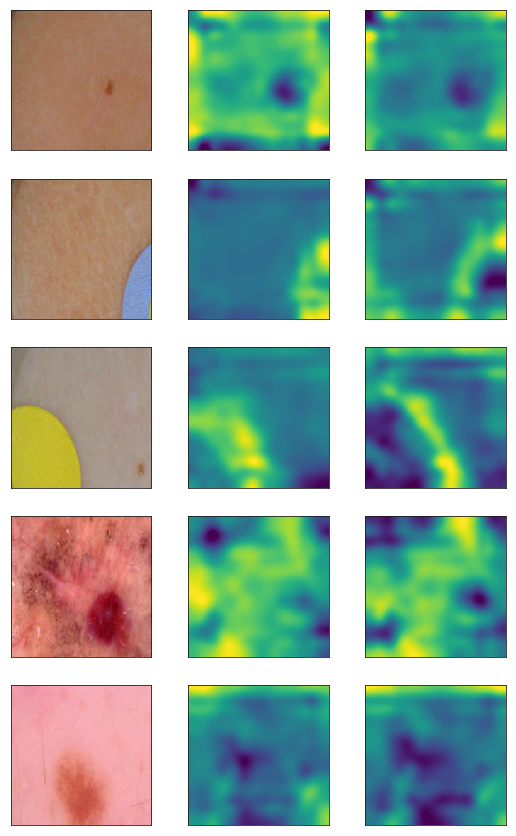

In [319]:
sns.reset_orig()
num_rows = 5
fig, axes = plt.subplots(ncols=3, nrows = num_rows, figsize=  (3*3, num_rows*3))
i_small  =0 
for i, (original_img, vanilla_sal, reg_sal, true_class) in enumerate(no_cancer_triples[:num_rows]):


    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow(vanilla_sal)
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,2].imshow(reg_sal)
    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)


In [325]:
vanilla_sal.shape

(224, 224)

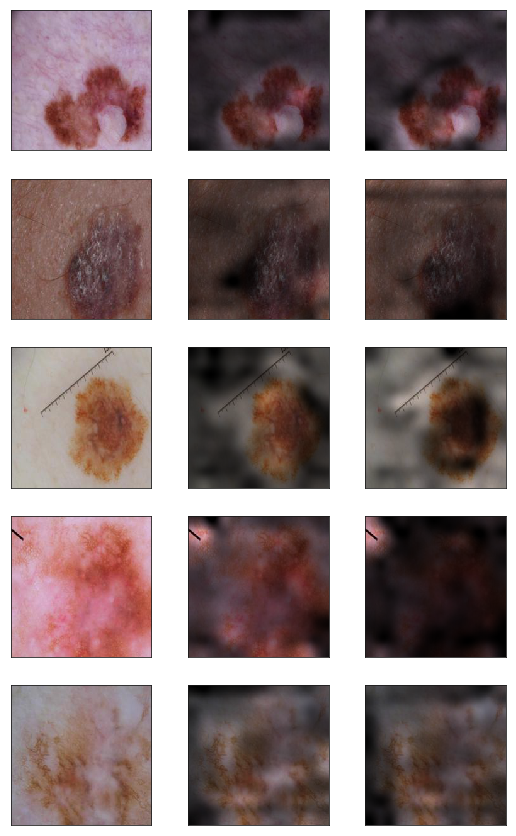

In [318]:
sns.reset_orig()
num_rows = 5
fig, axes = plt.subplots(ncols=3, nrows = num_rows, figsize=  (3*3, num_rows*3))
i_small  =0 
for i, (original_img, vanilla_sal, reg_sal, true_class) in enumerate(cancer_triples[:num_rows]):


    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow(vanilla_sal[:, :, None]*np.clip(original_img,0,1))
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,2].imshow(reg_sal[:, :, None]*np.clip(original_img,0,1))
    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
